# 🧩 LangGraph 入门与实战教程

---

## 🌐 什么是 LangGraph？

**LangGraph** 是 LangChain 团队推出的一个“流程图式”框架，  
它能用 **节点（Node） + 边（Edge）** 的方式来构建大语言模型应用。

如果说 **LangChain 是搭积木的框架**，  
那么 **LangGraph 就是“画流程图的框架”**。

它的底层原理是：  
> 把每个步骤（例如模型调用、判断分支、工具使用）变成一个节点（Node），  
> 然后用“有向图（Directed Graph）”把它们连接起来。  
> 模型每运行一步，就像在图中走了一条路径。

---

## ⚙️ LangGraph 的核心概念

| 名称 | 含义 | 举例 |
|------|------|------|
| **State（状态）** | 储存运行过程中的变量，例如消息列表、路由信息 | `messages`, `next` |
| **Node（节点）** | 图中的每个执行单元（函数） | 模型节点、判断节点、工具节点 |
| **Edge（边）** | 节点之间的连接 | `add_edge("a", "b")` |
| **Conditional Edge** | 根据条件选择路径 | `add_conditional_edges()` |
| **StateGraph** | 图的构建器 | 定义节点和连接 |
| **app = graph.compile()** | 编译成可运行的 LangGraph 应用 | 用 `app.invoke()` 调用 |

---

## 🔁 LangGraph 与 LangChain 的关系

| 对比项 | LangChain | LangGraph |
|--------|------------|------------|
| 编排方式 | 管道式（`Prompt | LLM | Parser`） | 图式（节点与边） |
| 适合场景 | 单链路任务（如问答、信息提取） | 多分支、多Agent、复杂对话逻辑 |
| 状态管理 | 一次性执行 | 有“State”，可跨节点共享 |
| 可视化 | 无 | 可自动生成流程图（Mermaid / PNG） |
| 代表概念 | Chain, Runnable | Graph, Node, Edge |

---

## 🎯 为什么要用 LangGraph？

✅ 把多步骤、多分支的逻辑清晰可视化  
✅ 支持循环、条件判断、并行、记忆  
✅ 状态可持久化，适合构建多Agent系统  
✅ 可与 LangChain 完美衔接  



# 1. 最小LangGraph（START → 模型 → END）

In [ ]:

"""
LangGraph 简单案例：
构建一个最小的有向图，流程是：
START → 模型节点 → END
"""

from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# ========== 1. 定义状态（State） ==========
# 存储对话消息
class State(TypedDict):
    # messages 是一个消息列表，Annotated + add_messages 表示支持自动追加消息
    messages: Annotated[List, add_messages]

# ========== 2. 定义大模型 ==========
llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url="https://www.dmxapi.cn/v1",
    #api_key="",  替换为你的 API Key 
    temperature=0)


# ========== 3. 定义节点函数 ==========
# 节点：调用大模型，并把回复加入到 state["messages"] 里
def model_node(state: State):
    reply = llm.invoke(state["messages"])   # 输入历史消息，调用模型
    return {"messages": [reply]}            # 返回新消息，自动加到 state

# ========== 4. 构建图结构 ==========
graph = StateGraph(State)          # 初始化图，指定 State 类型
graph.add_node("model", model_node) # 添加一个节点，名字叫 "model"
graph.add_edge(START, "model")      # 从 START 到 "model"
graph.add_edge("model", END)        # 从 "model" 到 END

# ========== 5. 编译 & 运行 ==========
app = graph.compile()

# 输入一条用户消息
result = app.invoke({"messages": [HumanMessage(content="请用一句话解释什么是 LangGraph。")]})

# 打印模型的最后一条回复
print("模型回答：", result["messages"][-1].content)


模型回答： LangGraph 是一种用于自然语言处理的图结构，旨在通过图形化的方式表示和处理语言中的语义关系和结构。


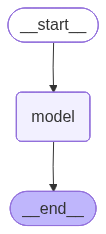

In [13]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# 2.分支路由（Router → Weather / Chat）

In [ ]:
# -*- coding: utf-8 -*-
"""
LangGraph 分支
"""

from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

# ========== 1. 定义状态 ==========
class State(TypedDict):
    messages: Annotated[List, add_messages]
    next: str  # 用来存储路由结果


# ========== 2. 定义大模型 ==========
llm = ChatOpenAI(
    model="gpt-4o-mini",
    base_url="https://www.dmxapi.cn/v1",
    #api_key="",  替换为你的 API Key 
    temperature=0
)


# ========== 3. 定义节点函数 ==========
def router_node(state: State):
    """路由节点：根据用户消息决定走 weather 还是 chat"""
    user_msg = state["messages"][-1].content
    if "天气" in user_msg:
        return {"next": "weather"}
    else:
        return {"next": "chat"}

def weather_node(state: State):
    """天气节点：根据内容返回天气"""
    user_msg = state["messages"][-1].content
    if "北京" in user_msg:
        reply = AIMessage(content="北京今天晴，26℃。")
    elif "济南" in user_msg:
        reply = AIMessage(content="济南今天小雨，23℃。")
    else:
        reply = AIMessage(content="暂时没有该城市的天气信息。")
    return {"messages": [reply]}

def chat_node(state: State):
    """闲聊节点：直接调用模型"""
    reply = llm.invoke(state["messages"])
    return {"messages": [reply]}


# ========== 4. 构建图 ==========
graph = StateGraph(State)

graph.add_node("router", router_node)
graph.add_node("weather", weather_node)
graph.add_node("chat", chat_node)

graph.add_edge(START, "router")

# 条件边：根据 state["next"] 决定走哪条路
graph.add_conditional_edges(
    "router",
    lambda state: state["next"],       # 根据 state["next"] 选择分支
    {"weather": "weather", "chat": "chat"}
)

graph.add_edge("weather", END)
graph.add_edge("chat", END)

# 编译
app = graph.compile()   


# ========== 5. 测试 ==========
print("=== 测试天气问题 ===")
result1 = app.invoke({"messages": [HumanMessage(content="请告诉我济南的天气")]})
print("回答：", result1["messages"][-1].content)

print("\n=== 测试闲聊问题 ===")
result2 = app.invoke({"messages": [HumanMessage(content="给我讲个笑话")]})
print("回答：", result2["messages"][-1].content)


=== 测试天气问题 ===
回答： 济南今天小雨，23℃。

=== 测试闲聊问题 ===
回答： 当然可以！这是一个简单的笑话：

有一天，一只鸡走进了图书馆。它走到图书馆员面前，咕咕叫了几声。图书馆员有些困惑，但还是给了它一本书。鸡拿着书走了出去。

第二天，鸡又来了，还是咕咕叫。图书馆员又给了它一本书。鸡又走了。

第三天，鸡再次来到图书馆，咕咕叫。图书馆员这次好奇了，决定跟着鸡看看它到底在做什么。

鸡走到一个池塘边，把书递给了一只青蛙。青蛙看了看书，摇了摇头，说：“呱，不是这个，不是这个！” 

希望这个笑话能让你笑一笑！


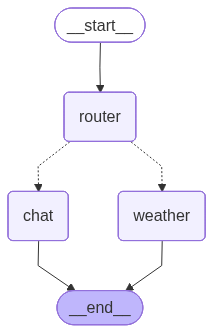

In [15]:

# ========== 6. 绘制图形 ==========
from IPython.display import Image, display

# 注意：这里用 app.get_graph()
display(Image(app.get_graph().draw_mermaid_png()))

# 3.多节点并行 + 汇聚结构

In [16]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage

# 定义状态
class State(TypedDict):
    messages: Annotated[List, add_messages]

# 定义几个最简单的节点函数
def node_a(state: State):
    return {"messages": [AIMessage(content="我是节点 A")]}
def node_b(state: State):
    return {"messages": [AIMessage(content="我是节点 B")]}
def node_c(state: State):
    return {"messages": [AIMessage(content="我是节点 C")]}
def node_d(state: State):
    return {"messages": [AIMessage(content="我是节点 D")]}

# 构建图
builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("d", node_d)

# 添加边
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 编译图
app = builder.compile()

# 打印运行一次的结果
result = app.invoke({"messages": []})
print([m.content for m in result["messages"]])


['我是节点 A', '我是节点 B', '我是节点 C', '我是节点 D']


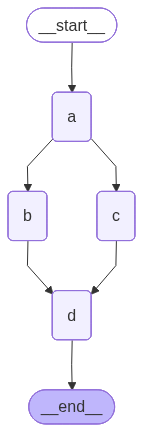

In [17]:
from IPython.display import Image, display
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(png_bytes))


# 4.带记忆（Memory）或循环（Loop）

['你好', '第 1 轮对话中……你可以回复“end”来停止。', '第 2 轮对话中……你可以回复“end”来停止。', '第 3 轮对话中……你可以回复“end”来停止。', '第 4 轮对话中……你可以回复“end”来停止。', '好的，本轮结束（共 5 轮）。']


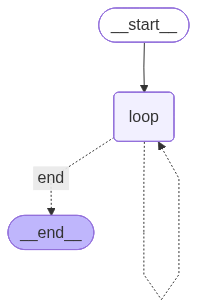

In [19]:
from typing import TypedDict, Annotated, List, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

# 1) 定义 State：包含 messages / turn / next
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    turn: int
    next: Literal["loop", "end"]  # 给条件边使用

# 2) 定义循环节点：直到用户说“结束”或到达最大轮数
MAX_TURNS = 5

def loop_node(state: State):
    last_msg = state["messages"][-1].content if state["messages"] else ""
    cur_turn = state.get("turn", 1)

    if "结束" in last_msg or cur_turn >= MAX_TURNS:
        reply = AIMessage(content=f"好的，本轮结束（共 {cur_turn} 轮）。")
        return {"messages": [reply], "turn": cur_turn, "next": "end"}
    else:
        reply = AIMessage(content=f"第 {cur_turn} 轮对话中……你可以回复“end”来停止。")
        return {"messages": [reply], "turn": cur_turn + 1, "next": "loop"}

# 3) 构建图
graph = StateGraph(State)
graph.add_node("loop", loop_node)
graph.add_edge(START, "loop")
graph.add_conditional_edges(
    "loop",
    lambda s: s["next"],          # 用 state["next"] 选择路径
    {"loop": "loop", "end": END}  # 回到自己或结束
)

# 4) 编译
app = graph.compile()

# 5) 运行一次（不输入“结束”，自动循环到 MAX_TURNS 停）
result = app.invoke({"messages": [HumanMessage(content="你好")], "turn": 1, "next": "loop"})
print([m.content for m in result["messages"]])

# 6) 画图
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
